In [19]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var, plot_cover

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
dim = 3
corr = 0.

beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [10]:
n_var = 10000
n_perms = None

n_boot = 500
n_run = 100

n_n_outer = 40
min_n_outer = 2
max_n_outer = 50

all_n_outer = np.logspace(np.log10(min_n_outer),
                          np.log10(max_n_outer), n_n_outer, base=10, dtype=int)
all_n_outer = np.unique(all_n_outer)
n_n_outer = len(all_n_outer)
    
all_n_inner = [3, 6, 10]
n_n_inner = len(all_n_inner)
method = 'exact' if n_perms is None else 'random'

In [13]:
%%time

all_shapley_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))

for i_outer, n_outer in enumerate(all_n_outer):
    for i_inner, n_inner in enumerate(all_n_inner):
        print('No:', n_outer, 'Ni:', n_inner)
        for i_run in range(n_run):
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_outer, i_inner, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_outer, i_inner, i_run] = shapley_results.full_first_indices
            all_total_results[i_outer, i_inner, i_run] = shapley_results.full_total_indices

No: 2 Ni: 3
No: 2 Ni: 6
No: 2 Ni: 10
No: 3 Ni: 3
No: 3 Ni: 6
No: 3 Ni: 10
No: 4 Ni: 3
No: 4 Ni: 6
No: 4 Ni: 10
No: 5 Ni: 3
No: 5 Ni: 6
No: 5 Ni: 10
No: 6 Ni: 3
No: 6 Ni: 6
No: 6 Ni: 10
No: 7 Ni: 3
No: 7 Ni: 6
No: 7 Ni: 10
No: 8 Ni: 3
No: 8 Ni: 6
No: 8 Ni: 10
No: 9 Ni: 3
No: 9 Ni: 6
No: 9 Ni: 10
No: 10 Ni: 3
No: 10 Ni: 6
No: 10 Ni: 10
No: 11 Ni: 3
No: 11 Ni: 6
No: 11 Ni: 10
No: 12 Ni: 3
No: 12 Ni: 6
No: 12 Ni: 10
No: 13 Ni: 3
No: 13 Ni: 6
No: 13 Ni: 10
No: 14 Ni: 3
No: 14 Ni: 6
No: 14 Ni: 10
No: 15 Ni: 3
No: 15 Ni: 6
No: 15 Ni: 10
No: 17 Ni: 3
No: 17 Ni: 6
No: 17 Ni: 10
No: 18 Ni: 3
No: 18 Ni: 6
No: 18 Ni: 10
No: 20 Ni: 3
No: 20 Ni: 6
No: 20 Ni: 10
No: 21 Ni: 3
No: 21 Ni: 6
No: 21 Ni: 10
No: 23 Ni: 3
No: 23 Ni: 6
No: 23 Ni: 10
No: 25 Ni: 3
No: 25 Ni: 6
No: 25 Ni: 10
No: 28 Ni: 3
No: 28 Ni: 6
No: 28 Ni: 10
No: 30 Ni: 3
No: 30 Ni: 6
No: 30 Ni: 10
No: 33 Ni: 3
No: 33 Ni: 6
No: 33 Ni: 10
No: 35 Ni: 3
No: 35 Ni: 6
No: 35 Ni: 10
No: 39 Ni: 3
No: 39 Ni: 6
No: 39 Ni: 10
No: 42 Ni: 3
No: 42 Ni: 

NameError: name 'results_SE' is not defined

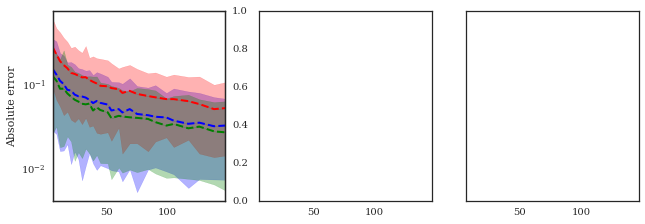

In [22]:
# Coverage probability
ci_prob = 0.10
error_type = 'absolute'
logscale = True
name = 'N_o'
savefigs = True
ci_method = 'bootstrap'

do_cover = False
if n_boot > 1 or method == 'random':
    do_cover = True

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_outer
    name_axes = 'N_o'
    axis = 0
else:
    x_ticks = all_n_outer
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)
if n_col > 3:
    assert n_col == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n_col/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n_col, figsize=(2.5*n_col+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
axes = [axes] if n_col == 1 else axes

for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Chose the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
            
    plot_error(results, true_results, x_ticks*N, ax=ax_err, error_type=error_type, logscale=logscale)

    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    if do_cover:
        plot_cover(results, true_results, x_ticks*N, ax=ax_cov, ci_prob=ci_prob, ci_method=ci_method)
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])
            
    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')
        
    ax_err.set_xlabel('$%s$' % (name))
    ax_err.grid()
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    
    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
if savefigs:
    name = './output/additive_gaussian_precision_dim_%d_%s_nboot_%d' % (dim, method, n_boot)
    name += '_nNo_%d_nNi_%d_rho_%.2f_Nv_%d_maxNo_%d_nrun_%d_%s.pdf' %\
        (n_n_outer, n_n_inner, corr, n_var, max_n_outer, n_run, error_type)
    fig.savefig(name)